In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

/home/joris/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/joris/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationESs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
print(torch.cuda.is_available())
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device("cpu")
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, padding='same', device=self.device),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 32, kernel_size=3, padding='same', device=self.device),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 16, kernel_size=3, padding='same', device=self.device),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2)
        )
        
        self.decoder = torch.nn.Sequential(
           torch.nn.Conv2d(16, 32, (3, 3), padding='same', device=self.device),
           torch.nn.ReLU(True),
           torch.nn.Upsample(size=(7, 7)),
           torch.nn.Conv2d(32, 64, (3, 3), padding='same', device=self.device),
           torch.nn.ReLU(True),
           torch.nn.Upsample(size=(14, 14)),
           torch.nn.Conv2d(64, 1, (3, 3), padding='same', device=self.device),
           torch.nn.ReLU(True),
           torch.nn.Upsample(size=(28, 28))
       )
            
        self.optimizer = torch.optim.SGD(self.parameters(), lr=1e-2)
        self.loss = torch.nn.MSELoss()
    
    def forward(self, x):
        y = self.encoder(x)
        y = self.decoder(y)
        return y

True


In [3]:
def train_encoder(encoder, x):
    pred = encoder.forward(x)
    loss = encoder.loss(pred, x)
    encoder.optimizer.zero_grad()
    loss.backward()
    encoder.optimizer.step()
    l = float(loss)
    return l

In [4]:
data = datasets.FashionMNIST("Fashion", download=True, transform=transforms.ToTensor())

In [5]:
auto_encoder = AutoEncoder()
auto_encoder

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): Upsample(size=(7, 7), mode=nearest)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU(inplace=True)
    (5): Upsample(size=(14, 14), mode=nearest)
    (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU

In [6]:
loaded = torch.utils.data.DataLoader(data, batch_size=2048, shuffle=True)

Training Batch 900 / 100
Training Batch 901 / 99
Training Batch 902 / 98
Training Batch 903 / 97
Training Batch 904 / 96
Training Batch 905 / 95
Training Batch 906 / 94
Training Batch 907 / 93
Training Batch 908 / 92
Training Batch 909 / 91
Training Batch 910 / 90
Training Batch 911 / 89
Training Batch 912 / 88
Training Batch 913 / 87
Training Batch 914 / 86
Training Batch 915 / 85
Training Batch 916 / 84
Training Batch 917 / 83
Training Batch 918 / 82
Training Batch 919 / 81
Training Batch 920 / 80
Training Batch 921 / 79
Training Batch 922 / 78
Training Batch 923 / 77
Training Batch 924 / 76
Training Batch 925 / 75
Training Batch 926 / 74
Training Batch 927 / 73
Training Batch 928 / 72
Training Batch 929 / 71


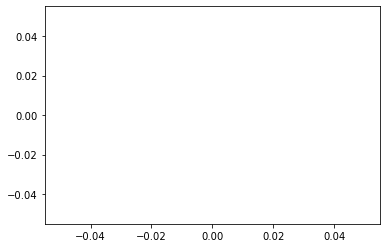

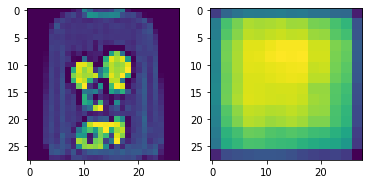

In [11]:
%matplotlib inline
loss = []
max = 100
for data in loaded:
    #print(data[0].shape)
    print(f"Training Batch {1000-max} / {max}")
    train_encoder(auto_encoder, data[0])
    max -= 1
    if max < 0:
        break
plt.plot(loss)
plt.figure()
image = next(d for d in loaded)[0][0].reshape(28, 28)
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(auto_encoder.forward(image.reshape(1, 1, 28, 28)).detach().reshape(28, 28))